## Calculadora de Investimentos do Aprendiz Moderno

Utilizando dados históricos para calcular a performance de uma carteira fictícia

In [49]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import style
import seaborn as sns
import datetime as dt
sns.set_theme()
style.use('ggplot')

pd.set_option('display.max_rows', 1000)

In [2]:
def dividendo_por_acao(lista, data):
    dividendo = lista[(lista.index.month == data.month) & (lista.index.year == data.year)]
    dividendo = dividendo.sum()
    return dividendo


def calcula_investimento(ticker, inicio='2010-01-01', termino='2020-01-01', aporte_mensal=1000.0):
    lista_de_dividendos = yf.Ticker(ticker).dividends
    hist = yf.download(ticker, start=inicio, end=termino, interval='1mo')
    hist = hist.dropna()
    hist['valor_investido'] = 0.00
    hist['aporte_mensal'] = aporte_mensal
    hist['aporte_total'] = 0.00
    hist['total_acoes'] = 0.00
    hist['resto'] = 0.00
    hist['dividendos'] = 0.00
    total_de_linhas = hist.shape[0]

    for i in range(0, total_de_linhas):
        linha = hist.iloc[i,:]
        data = hist.index[i]
        valor_de_fechamento = linha['Adj Close']
        if i > 0:
            linha_anterior = hist.iloc[i-1, :]
            acoes_anterior = linha_anterior['total_acoes']
            resto_anterior = linha_anterior['resto']
        else:
            # i == 0
            acoes_anterior = 0.00
            resto_anterior = 0.00
            
        dividendo = dividendo_por_acao(lista_de_dividendos, data)
        total_dividendos = dividendo*acoes_anterior
        aporte_total = aporte_mensal + resto_anterior + total_dividendos
        novas_acoes = int(aporte_total/valor_de_fechamento)
        total_acoes = acoes_anterior + novas_acoes
        valor_investido = total_acoes*valor_de_fechamento
        resto = aporte_total - novas_acoes*valor_de_fechamento
        # substituir valores
        hist.at[data, 'valor_investido'] = valor_investido
        hist.at[data, 'aporte_total'] = aporte_total
        hist.at[data, 'total_acoes'] = total_acoes
        hist.at[data, 'resto'] = resto
        hist.at[data, 'dividendos'] = total_dividendos

    return hist

In [27]:
carteira = [
    {
        "ticker":"ITUB3.SA",
        "inicio":"2010-01-01",
        "termino":"2020-10-10",
        "aporte_mensal":200.0
    },
    {
        "ticker":"ABEV3.SA",
        "inicio":"2010-01-01",
        "termino":"2020-10-10",
        "aporte_mensal":300.0
    },
    {
        "ticker":"B3SA3.SA",
        "inicio":"2010-01-01",
        "termino":"2020-10-10",
        "aporte_mensal":300.0
    },
    {
        "ticker":"WEGE3.SA",
        "inicio":"2010-01-01",
        "termino":"2020-10-10",
        "aporte_mensal":300.0
    },
    {
        "ticker":"EGIE3.SA",
        "inicio":"2010-01-01",
        "termino":"2020-10-10",
        "aporte_mensal":200.0
    }
]

In [28]:
def calcula_carteira(portfolio):
    COLS = ['data', 'ticker', 'valor_investido', 'aporte_mensal', 'aporte_total', 'total_acoes', 'dividendos']
    resultado = pd.DataFrame(columns=COLS)
    if len(portfolio) > 0:
        for acao in portfolio:
            try:
                hist = calcula_investimento(
                    ticker=acao['ticker'], inicio=acao['inicio'], termino=acao['termino'], aporte_mensal=acao['aporte_mensal']
                    )
                print('Ativo calculado!')
                hist = hist.reset_index()
                hist = hist.rename(columns={'Date':'data'})
                hist['ticker'] = acao['ticker']
                resultado = resultado.append(hist[COLS], ignore_index=True)
            except:
                print('Não foi possível calcular o ticker: ', acao['ticker'])
                pass
        return resultado
    else:
        print('A carteira precisa ter pelo menos 1 ativo.')

In [29]:
df = calcula_carteira(carteira)

[*********************100%***********************]  1 of 1 completed
Ativo calculado!
[*********************100%***********************]  1 of 1 completed
Ativo calculado!
[*********************100%***********************]  1 of 1 completed
Ativo calculado!
[*********************100%***********************]  1 of 1 completed
Ativo calculado!
[*********************100%***********************]  1 of 1 completed
Ativo calculado!


In [51]:
def cria_grafico(resultado):
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(25, 15))
    fig.suptitle('Performance da carteira', size=28, weight='bold')

    formato_moeda = ticker.StrMethodFormatter('R${x:,.0f}')
    ax1.yaxis.set_major_formatter(formato_moeda)
    ax2.yaxis.set_major_formatter(formato_moeda)
    ax3.yaxis.set_major_formatter(formato_moeda)
    ax4.yaxis.set_major_formatter(formato_moeda)

    ax1.set_title('Total investido em R$')
    ax2.set_title('Total Aportado por Ação')
    ax3.set_title('Dividendos Acumulados')
    ax4.set_title('Total de dividendos recebidos')

    # pivot tables
    pivot_aportes = resultado.pivot(index='data', columns='ticker', values='aporte_mensal').fillna(0)
    pivot_dividendos = resultado.pivot(index='data', columns='ticker', values='dividendos').fillna(0)
    pivot_valor_investido = resultado.pivot(index='data', columns='ticker', values='valor_investido').fillna(0)
    pivot_dividendo_acumulado = pivot_dividendos.cumsum()

    pivot_aportes.plot.area(ax=ax2, stacked=True)
    pivot_valor_investido.plot.area(ax=ax1, stacked=True)
    pivot_dividendo_acumulado.plot.area(ax=ax3, stacked=True)
    pivot_dividendos.plot.line(ax=ax4, stacked=False)

    return fig

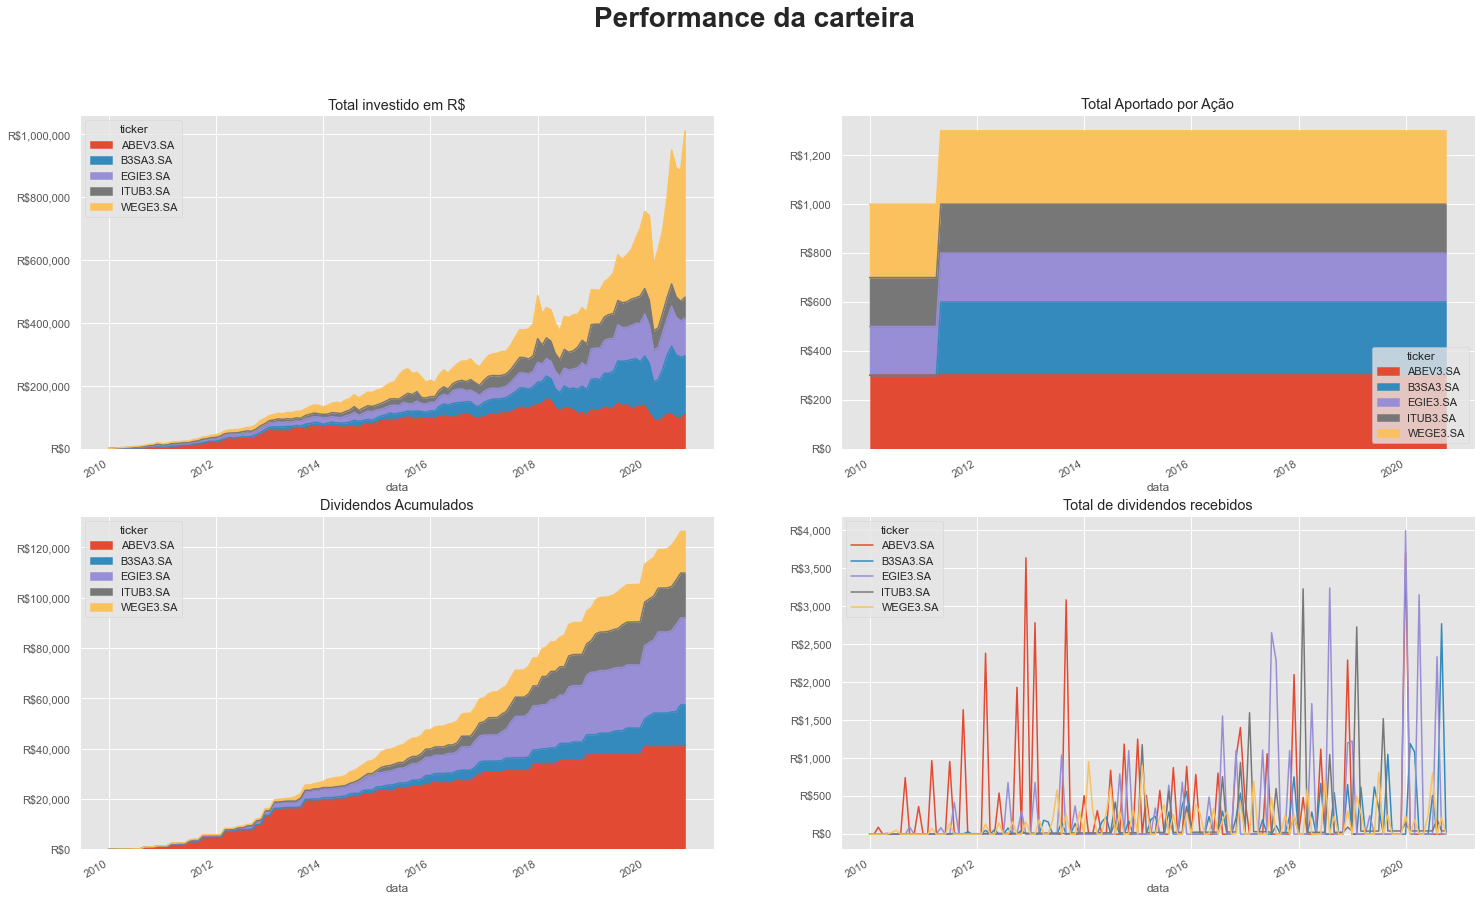

In [52]:
figura = cria_grafico(resultado=df)